In [225]:
import os
import torch
import torchvision.models as models
import torch.nn as nn
# from deepproblog.dataset import Dataset, DataLoader, QueryDataset
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as TorchDataset
from deepproblog.dataset import Dataset as DPLDataset
from problog.logic import Term, Constant, Var, list2term
from deepproblog.dataset import ImageDataset
from deepproblog.evaluate import get_confusion_matrix
from torch.amp.autocast_mode import autocast
from torchvision import models, transforms, datasets
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from deepproblog.dataset import DataLoader as DPLDataLoader

import torch.optim as optim
from torchvision import models, transforms
from PIL import Image
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
from deepproblog.utils.stop_condition import EpochStop
from deepproblog.optimizer import SGD

from deepproblog.model import Model
from deepproblog.network import Network
from deepproblog.engines import ExactEngine
from deepproblog.query import Query
from deepproblog.train import train_model
import torch.nn as nn
import torch.nn.functional as F

from torch.amp.grad_scaler import GradScaler
from torch.amp.autocast_mode import autocast

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import glob
from retinaface import RetinaFace
import csv

In [226]:
# GLOBAL VARS
dataset_size = None
lr_faces = 1e-4
lr_scenes = 1e-4
lr_combination_model = 5e-4
lr_model = 1e-4
batch_size = 32
log_iter = 2
epochs = 30
global_emotion_label = 'emo8'
nr_clusters = 9

In [227]:
# Directories
script_dir = os.getcwd()
print("script_dir:", script_dir)
base_dir = os.path.dirname(os.path.dirname(script_dir))
print("base_dir:", base_dir)
prolog_dir = os.path.join(base_dir, "prolog")
data_dir = os.path.join(base_dir, "data")
print("data_dir:", data_dir)
findingemo_dir = os.path.join(data_dir, "FindingEmo_Images")
print("findingemo_dir:", findingemo_dir)
prolog_dir = os.path.join(base_dir, "code", "prolog")
print("prolog_dir:", prolog_dir)
model_dir = os.path.join(base_dir, "code", "models")
print("model_dir:", model_dir)
cropped_faces_dir = os.path.join(findingemo_dir, "faces")
print("cropped_faces_dir:", cropped_faces_dir)

script_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\code\notebooks
base_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition
data_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\data
findingemo_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\data\FindingEmo_Images
prolog_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\code\prolog
model_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\code\models
cropped_faces_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\data\FindingEmo_Images\faces


In [228]:
df = pd.read_pickle(os.path.join(script_dir, "clean_findingemo.pkl"))
print("Dataframe loaded. Number of entries:", len(df))

Dataframe loaded. Number of entries: 25867


In [229]:
EMOTION_SETS = [["Serenity", "Joy", "Ecstasy"],
                    ["Acceptance", "Trust", "Admiration"],
                    ["Apprehension", "Fear", "Terror"],
                    ["Distraction", "Surprise", "Amazement"],
                    ["Pensiveness", "Sadness", "Grief"],
                    ["Boredom", "Disgust", "Loathing"],
                    ["Annoyance", "Anger", "Rage"],
                    ["Interest", "Anticipation", "Vigilance"]]
                
def emo_8_mapping(e):
    for leaf in EMOTION_SETS:
        if e in leaf:
            return leaf[1]
        
def emo_3_mapping(v):
    if v < -1:
        return "sad"
    if v > 1:
        return "happy"
    else:
        return "neutral"

In [230]:
if global_emotion_label == 'emo8':
    df['emotion'] = df['emotion'].apply(emo_8_mapping).str.lower()
if global_emotion_label == 'emotion':
    df['emotion'] = df['emotion'].str.lower()
if global_emotion_label == 'emo3':
    df['emotion'] = df['valence'].apply(emo_3_mapping).str.lower()

In [231]:
df.head()

,image_path,tags,age,valence,arousal,emotion,dec_factors,ambiguity
0,Run_2/Loving toddlers sports/haiti-kids.jpg,Undefined,Children,0,2,trust,"BodyLanguage,FacialExpression",0
1,Run_2/Frustrated forty-something office/team-w...,Undefined,Young Adults,0,2,anticipation,FacialExpression,0
2,Run_1/Violent youth festival/1042373588.jpg,Undefined,Young Adults,2,2,anticipation,BodyLanguage,3
3,Run_2/Remorseful toddlers court of law/dcfs-co...,Undefined,Adults,1,2,anticipation,"BodyLanguage,FacialExpression",4
4,Run_2/Shame elderly sports/3364887-46.jpg,Undefined,Adults,0,3,fear,ConflictCtxtPerson,0


In [232]:
len(df)

25867

In [233]:
if dataset_size is not None:
    df = df.iloc[:dataset_size]

In [234]:
fe_labels = df['emotion'].unique().tolist()
fe_labels.sort()
print("Emotion labels:", fe_labels)

Emotion labels: ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust']


In [235]:
fer_classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [236]:
# Create a dictionary with the average valence arousal values for each emotion label
emotion_va = {}

for emo in fe_labels:
    emo_df = df[df['emotion'] == emo]
    avg_valence = emo_df['valence'].mean()
    avg_arousal = emo_df['arousal'].mean()
    emotion_va[emo] = (avg_valence, avg_arousal)

In [237]:
emotion_va

{'anger': (-1.5756457564575646, 3.5912259122591226),
 'anticipation': (0.5624470428740891, 2.463650228774784),
 'disgust': (-0.876, 2.441),
 'fear': (-1.3390254060807996, 3.239067055393586),
 'joy': (1.9020501138952164, 2.9552961275626424),
 'sadness': (-1.5707317073170732, 3.4221388367729833),
 'surprise': (0.47635135135135137, 2.5664414414414414),
 'trust': (1.4142011834319526, 2.5694561848408)}

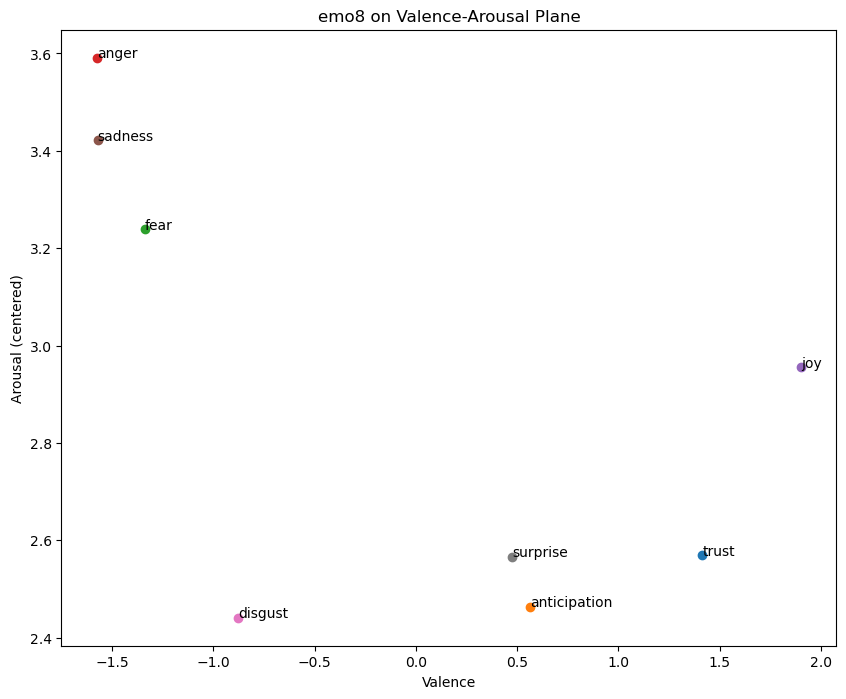

In [238]:
VALENCE_BINS = np.linspace(-3, 3, num=7)
AROUSAL_BINS = np.linspace(0, 6, num=7)

def to_bin(value, bins):
    return int(np.abs(bins - value).argmin())

plt.figure(figsize=(10, 8))
emotion_va_bins = {}

for emo in df['emotion'].unique():
    avg_valence, avg_arousal = emotion_va[emo]
    valence_bin = to_bin(avg_valence, VALENCE_BINS)
    arousal_bin = to_bin(avg_arousal, AROUSAL_BINS)
    emotion_va_bins[emo] = (valence_bin, arousal_bin)
    plt.scatter(avg_valence, avg_arousal, label=emo)
    plt.text(avg_valence, avg_arousal, emo)

plt.xlabel('Valence')
plt.ylabel('Arousal (centered)')
plt.title(f'{global_emotion_label} on Valence-Arousal Plane')
plt.show()

In [239]:
df['valence_bin'] = df['valence'].apply(lambda x: to_bin(x, VALENCE_BINS))
df['arousal_bin'] = df['arousal'].apply(lambda x: to_bin(x, AROUSAL_BINS))

In [240]:
df.head()

,image_path,tags,age,valence,arousal,emotion,dec_factors,ambiguity,valence_bin,arousal_bin
0,Run_2/Loving toddlers sports/haiti-kids.jpg,Undefined,Children,0,2,trust,"BodyLanguage,FacialExpression",0,3,2
1,Run_2/Frustrated forty-something office/team-w...,Undefined,Young Adults,0,2,anticipation,FacialExpression,0,3,2
2,Run_1/Violent youth festival/1042373588.jpg,Undefined,Young Adults,2,2,anticipation,BodyLanguage,3,5,2
3,Run_2/Remorseful toddlers court of law/dcfs-co...,Undefined,Adults,1,2,anticipation,"BodyLanguage,FacialExpression",4,4,2
4,Run_2/Shame elderly sports/3364887-46.jpg,Undefined,Adults,0,3,fear,ConflictCtxtPerson,0,3,3


In [241]:
emotion_va_bins

{'trust': (4, 3),
 'anticipation': (4, 2),
 'fear': (2, 3),
 'anger': (1, 4),
 'joy': (5, 3),
 'sadness': (1, 3),
 'disgust': (2, 2),
 'surprise': (3, 3)}

In [242]:
# # Change the bins a bit to be able to seperate them
# # Anger should be in a higher arousal bin
# emotion_va_bins['anger'] = (1, 5)

# # Surprise is typically more aroused so anticipation needs a higher arousal bin
# emotion_va_bins['surprise'] = (3, 4)

# # Fear should have a higher arousal
# emotion_va_bins['fear'] = (2, 3)

# # Trust should have a bit of a lower arousal
# emotion_va_bins['trust'] = (4, 2)

# # Disgust can be a more negative as well
# emotion_va_bins['disgust'] = (3, 4)

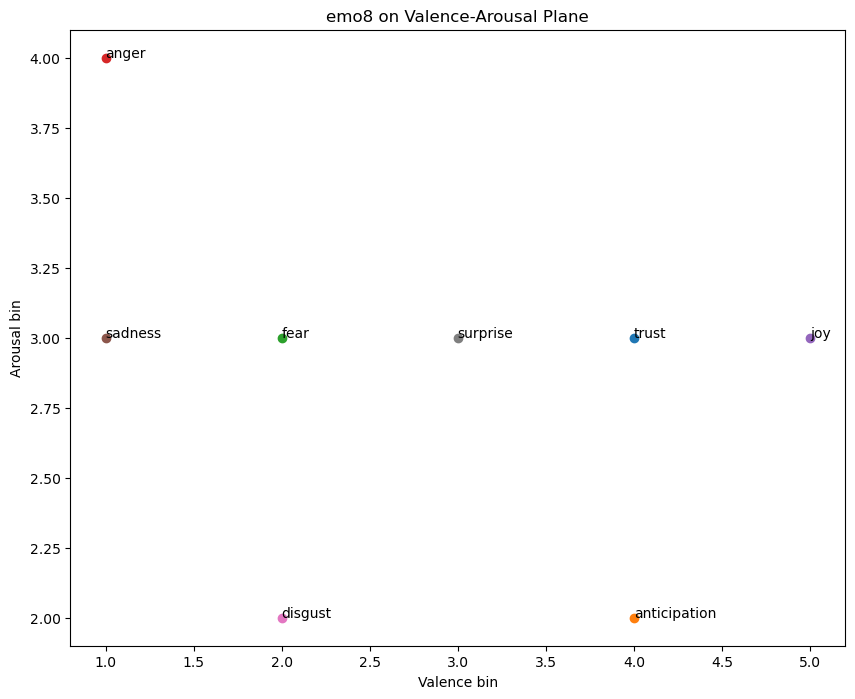

In [243]:
# Now plot the bins
plt.figure(figsize=(10, 8))

for emo in df['emotion'].unique():
    valence_bin, arousal_bin = emotion_va_bins[emo]
    plt.scatter(valence_bin, arousal_bin, label=emo)
    plt.text(valence_bin, arousal_bin, emo)

plt.xlabel('Valence bin')
plt.ylabel('Arousal bin')
plt.title(f'{global_emotion_label} on Valence-Arousal Plane')
plt.show()

In [244]:
# Load category names
scene_categories_path = os.path.join(data_dir, "places365/categories_places365.txt")
with open(scene_categories_path) as f:
    scene_categories = [line.strip().split(' ')[0][3:] for line in f]
    # If there is a / in the category name, replace it with _
    scene_categories = [cat.replace('/', '_') for cat in scene_categories]
print("Length of scene categories:", len(scene_categories))  # Should be 365

Length of scene categories: 365


In [245]:
# get the counts of the labels of emotion
df['emotion'].value_counts()

emotion
joy             7024
anticipation    5901
trust           3549
sadness         2665
anger           2439
fear            2401
disgust         1000
surprise         888
Name: count, dtype: int64

In [246]:
if dataset_size is not None:
    N = dataset_size
else:
    N = len(df)
    
indices = list(range(N))

train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42)
print("Train indices length:", len(train_indices))
print("Test indices length:", len(test_indices))

Train indices length: 20693
Test indices length: 5174


In [247]:
print(torch.cuda.is_available())
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# let cuDNN pick the fastest kernels for this image size
torch.backends.cudnn.benchmark = True

True


In [248]:
from transformers import AutoImageProcessor, AutoModelForImageClassification, AutoConfig


emotion_transform = AutoImageProcessor.from_pretrained("trpakov/vit-face-expression", use_fast=True)
face_model_base = AutoModelForImageClassification.from_pretrained("trpakov/vit-face-expression")
face_model_base.to(DEVICE)
config = AutoConfig.from_pretrained("trpakov/vit-face-expression")
print(config.id2label)

{0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}


In [249]:
# Delete the last layer so I can use it as a feature extractor
face_model_base = nn.Sequential(*list(face_model_base.children())[:-1])

In [250]:
face_model_base

Sequential(
  (0): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermediate_act_fn): GEL

In [251]:
scene_processor = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load pretrained Places365 ResNet18
scene_model_base = models.resnet18(num_classes=365)
weights_url = "http://places2.csail.mit.edu/models_places365/resnet18_places365.pth.tar"
checkpoint = torch.hub.load_state_dict_from_url(weights_url, map_location="cpu")
state_dict = {k.replace("module.", ""): v for k, v in checkpoint["state_dict"].items()}
scene_model_base.load_state_dict(state_dict)
scene_model_base.to(DEVICE)
print("Loaded pretrained models")

Loaded pretrained models


In [252]:
scene_model_base

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [253]:
scene_model_base = nn.Sequential(*list(scene_model_base.children())[:-1])

In [254]:
scene_model_base

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [255]:
df_boxes = pd.read_csv(os.path.join(findingemo_dir, "face_boxes_5.csv"))
# Based on boxes_df we can add the column nr_faces for each original image in df
df['nr_faces'] = df.index.map(df_boxes['index'].value_counts()).fillna(0).astype(int)

In [256]:
get_category_name = lambda idx: scene_categories[idx]

In [257]:
class FacesDataset(ImageDataset):
    def __init__(self, indices):
        super().__init__(os.path.join(findingemo_dir, "faces_5"), extension="jpg", transform=emotion_transform)
        self.indices = indices
    
    def __getitem__(self, i):
        if isinstance(i, tuple):
            i = tuple(int(x.value) if isinstance(x, Constant) else x for x in i)
        
        tensor = super().__getitem__("img_{}_face_{}".format(*i))
        return tensor['pixel_values'][0]
    
    def __len__(self):
        return len(self.indices)
    
    def to_query(self, i):
        pass
    
faces_dataset = FacesDataset(indices)

In [258]:
from abc import ABC, abstractmethod
from pathlib import Path

class ImageDatasetExtension(DPLDataset, ABC):
    def __init__(self, root, extension="png", transform=None):
        super().__init__()
        self.root = Path(root)
        self.transform = transform
        self.extension = extension

    def __getitem__(self, index, extension=None):
        if type(index) is tuple:
            index = index[0]
        if extension is None:
            extension = self.extension
        p = self.root / "{}.{}".format(index, extension)
        with open(p, "rb") as f:
            img = Image.open(f)
            img = img.convert("RGB")
            if self.transform is not None:
                img = self.transform(img)
        return img

In [259]:
class SceneDataset(ImageDatasetExtension):
    def __init__(self, indices):
        super().__init__(os.path.join(findingemo_dir), extension="jpg", transform=scene_processor)
        self.indices = indices

    def __getitem__(self, i):
        if isinstance(i, tuple):
            i = tuple(int(x.value) if isinstance(x, Constant) else x for x in i)
        img_path = df.loc[i]['image_path']
        extension = img_path.rsplit('.', 1)[1]
        img_path_no_ext = img_path.rsplit('.', 1)[0]
        tensor = super().__getitem__(img_path_no_ext, extension = extension)
        return tensor
    
    def __len__(self):
        return len(self.indices)
    
    def to_query(self, i):
        pass

scenes_dataset = SceneDataset(indices)

In [260]:
y1 = face_model_base(faces_dataset[(0, 0)].to(DEVICE).unsqueeze(0))
y1 = y1.last_hidden_state[:, 0, :]

In [261]:
y2 = scene_model_base(scenes_dataset[0].to(DEVICE).unsqueeze(0))

In [262]:
y2 = y2.view(y2.size(0), -1)

In [263]:
y2.shape

torch.Size([1, 512])

In [264]:
def save_pretrained_logits_separately(indices, output_dir):
    """
    Save pre-computed logits from pretrained models to separate files.
    
    Args:
        indices: list of sample indices to process
        output_dir: base directory to save the logits
    """
    # Create output directories
    scene_dir = os.path.join(output_dir, "scenes")
    faces_dir = os.path.join(output_dir, "faces")
    os.makedirs(scene_dir, exist_ok=True)
    os.makedirs(faces_dir, exist_ok=True)
    
    # Set models to eval mode
    face_model_base.eval()
    scene_model_base.eval()
    
    for img_idx in tqdm(indices, desc="Saving pretrained logits"):
        # ----- PROCESS SCENE -----
        scene_img = scenes_dataset[(img_idx,)].to(DEVICE).unsqueeze(0)  # (1, C, H, W)
        
        with torch.no_grad():
            scene_logits = scene_model_base(scene_img)
            scene_logits = scene_logits.view(scene_logits.size(0), -1)
        
        # Save scene logits
        scene_file = os.path.join(scene_dir, f"scene_{img_idx}.pt")
        torch.save(scene_logits.cpu(), scene_file)
        
        # ----- PROCESS FACES -----
        face_rows = df_boxes[df_boxes['index'] == img_idx].sort_values('face_rank')
        
        for _, row in face_rows.iterrows():
            face_rank = int(row['face_rank'])
            face_tensor = faces_dataset[(img_idx, face_rank)]
            
            with torch.no_grad():
                face_tensor = face_tensor.to(DEVICE).unsqueeze(0)  # (1, C, H, W)
                outputs = face_model_base(face_tensor)  # Returns ImageClassifierOutput
                face_logits = outputs.last_hidden_state[:, 0, :]  # (1, hidden_size)
            
            # Save face logits
            face_file = os.path.join(faces_dir, f"face_{img_idx}_{face_rank}.pt")
            torch.save(face_logits.cpu(), face_file)
    
    print(f"\nLogits saved to:")
    print(f"  Scenes: {scene_dir}")
    print(f"  Faces: {faces_dir}")

# Usage:
# save_pretrained_logits_separately(indices, output_dir=os.path.join(data_dir, "pretrained_backbone"))

# DPL with symbolic knowledge about the data

In [265]:
class DeviceAwareModule(nn.Module):
    """Wrapper that automatically handles device placement for any module"""
    def __init__(self, module):
        super().__init__()
        self.module = module
    
    def forward(self, *args, **kwargs):
        # Move all tensor inputs to model's device
        device = next(self.module.parameters()).device
        
        def to_device(x):
            if isinstance(x, torch.Tensor):
                return x.to(device)
            elif isinstance(x, (list, tuple)):
                return type(x)(to_device(item) for item in x)
            elif isinstance(x, dict):
                return {k: to_device(v) for k, v in x.items()}
            return x
        
        args = to_device(args)
        kwargs = to_device(kwargs)
        return self.module(*args, **kwargs)
    
    def __getattr__(self, name):
        try:
            return super().__getattr__(name)
        except AttributeError:
            return getattr(self.module, name)

In [266]:
LABEL_TO_ID = {emo: i for i, emo in enumerate(fe_labels)}
print("LABEL_TO_ID:", LABEL_TO_ID)

LABEL_TO_ID: {'anger': 0, 'anticipation': 1, 'disgust': 2, 'fear': 3, 'joy': 4, 'sadness': 5, 'surprise': 6, 'trust': 7}


In [267]:
from deepproblog.utils.confusion_matrix import ConfusionMatrix

from sklearn.metrics import confusion_matrix as sklearn_cm, precision_recall_fscore_support

def evaluate_dpl_with_metrics(model, dataset):
    """Enhanced DPL evaluate function that returns detailed metrics"""
    from deepproblog.utils.confusion_matrix import ConfusionMatrix
    
    confusion_matrix = ConfusionMatrix()
    model.eval()
    
    all_labels = []
    all_preds = []
    
    for i, gt_query in enumerate(tqdm(dataset.to_queries(), desc="Evaluating DPL", leave=False)):
        test_query = gt_query.variable_output()
        answer = model.solve([test_query])[0]
        actual = str(gt_query.output_values()[0])
        
        if len(answer.result) == 0:
            predicted = "no_answer"
        else:
            max_ans = max(answer.result, key=lambda x: answer.result[x])
            p = answer.result[max_ans]
            predicted = str(max_ans.args[gt_query.output_ind[0]])
        
        confusion_matrix.add_item(predicted, actual)
        all_labels.append(actual)
        all_preds.append(predicted)
    
    # Convert to numpy arrays with label indices
    label_to_idx = {str(i): i for i in range(len(fe_labels))}
    y_true = np.array([label_to_idx.get(label, -1) for label in all_labels])
    y_pred = np.array([label_to_idx.get(pred, -1) for pred in all_preds])
    
    # Remove any "no_answer" predictions (-1)
    valid_mask = (y_true >= 0) & (y_pred >= 0)
    y_true = y_true[valid_mask]
    y_pred = y_pred[valid_mask]
    
    # Calculate sklearn confusion matrix
    cm = sklearn_cm(y_true, y_pred, labels=range(len(fe_labels)))
    
    # Per-class metrics
    precision, recall, f1, support = precision_recall_fscore_support(
        y_true, y_pred, average=None, labels=range(len(fe_labels)), zero_division=0
    )
    
    # Overall accuracy
    accuracy = confusion_matrix.accuracy()
    
    return {
        'accuracy': accuracy,
        'confusion_matrix': cm,
        'dpl_confusion_matrix': confusion_matrix,
        'y_true': y_true,
        'y_pred': y_pred,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'support': support
    }


def print_dpl_detailed_metrics(results, label_names):
    """Print detailed metrics for DPL results"""
    print(f"\n{'='*70}")
    print(f"Overall Metrics:")
    print(f"{'='*70}")
    print(f"Accuracy: {results['accuracy']:.4f}")
    
    print(f"\n{'='*70}")
    print(f"Per-Class Metrics:")
    print(f"{'='*70}")
    print(f"{'Emotion':<15} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<10}")
    print(f"{'-'*70}")
    
    for i, label in enumerate(label_names):
        print(f"{label:<15} {results['precision'][i]:<12.4f} "
              f"{results['recall'][i]:<12.4f} {results['f1'][i]:<12.4f} "
              f"{int(results['support'][i]):<10}")
    
    # Macro averages
    print(f"{'-'*70}")
    print(f"{'Macro Avg':<15} {results['precision'].mean():<12.4f} "
          f"{results['recall'].mean():<12.4f} {results['f1'].mean():<12.4f} "
          f"{int(results['support'].sum()):<10}")
    
    # Weighted averages
    weights = results['support'] / results['support'].sum()
    weighted_precision = (results['precision'] * weights).sum()
    weighted_recall = (results['recall'] * weights).sum()
    weighted_f1 = (results['f1'] * weights).sum()
    
    print(f"{'Weighted Avg':<15} {weighted_precision:<12.4f} "
          f"{weighted_recall:<12.4f} {weighted_f1:<12.4f} "
          f"{int(results['support'].sum()):<10}")

In [268]:
x = torch.load(data_dir + "/pretrained_logits/faces/face_0_0.pt")

In [269]:
print(x.shape)

torch.Size([7])


# Initialize the models, network and final DPL model

In [270]:
from deepproblog.utils.standard_networks import MLP
face_val_model_raw = MLP(
    768,        # input size
    256, 64,   # hidden layers
    len(VALENCE_BINS),       # output size (valence bins)   
    activation=nn.ReLU,
    softmax=False,   
    batch=True
)
face_val_model = DeviceAwareModule(face_val_model_raw).to(DEVICE)

In [271]:
class FaceValDataset(TorchDataset):
    def __init__(self, indices, feature_dir = os.path.join(data_dir, "pretrained_backbone", "faces")):
        self.indices = indices
        self.feature_dir = feature_dir

    def __getitem__(self, idx):
        if isinstance(idx, (tuple, list)):
            idx = idx[0]
        if isinstance(idx, Constant):
            idx = int(idx.value)

        idx = self.indices[idx]    
        valence_bin = df.loc[idx]['valence_bin']
        face_feature_list = []
        for _, box_row in df_boxes[df_boxes['index'] == idx].sort_values('face_rank').iterrows():
            face_rank = int(box_row['face_rank'])
            feature_path = os.path.join(self.feature_dir, f"face_{idx}_{face_rank}.pt")
            face_feature = torch.load(feature_path)
            face_feature_list.append(face_feature)

        if len(face_feature_list) == 0:
            face_avg = torch.zeros(768)

        else:
            face_avg = torch.mean(torch.stack(face_feature_list), dim=0)

        face_avg = face_avg.squeeze()

        return face_avg.to(DEVICE), valence_bin
    
    def __len__(self):
        return len(self.indices)
        

In [272]:
face_val_train_dataset = FaceValDataset(train_indices)
face_val_test_dataset = FaceValDataset(test_indices)

face_val_train_loader = DataLoader(face_val_train_dataset, batch_size=batch_size, shuffle=True)
face_val_test_loader = DataLoader(face_val_test_dataset, batch_size=batch_size, shuffle=False)

In [273]:
def custom_loss(logits, y, weight_tensor, ce_weight, reg_weight, adjacent_weight=0.3):
    """
    Loss function that rewards predictions within ±1 bin
    
    Args:
        logits: model predictions (B, num_bins)
        y: true labels (B,)
        weight_tensor: class weights for CE loss
        ce_weight: weight for exact match CE loss
        reg_weight: weight for regression loss
        adjacent_weight: weight for adjacent bin reward (default 0.3)
    """
    probs = logits.softmax(dim=1)  # (B, num_bins)
    num_bins = logits.size(1)
    
    # 1. Regression loss (smooth L1)
    bins = torch.arange(num_bins, device=DEVICE).float()
    v_hat = (probs * bins).sum(dim=1)
    reg_loss = F.smooth_l1_loss(v_hat, y.float())
    
    # 2. Exact match CE loss
    ce_loss = F.cross_entropy(logits, y, weight=weight_tensor)
    
    # 3. Adjacent bin reward: create soft targets
    # For each true label, also give credit to ±1 bins
    soft_targets = torch.zeros_like(probs)
    batch_size = y.size(0)
    
    for i in range(batch_size):
        true_bin = y[i].item()
        # Main target gets full weight
        soft_targets[i, true_bin] = 1.0
        
        # Adjacent bins get partial weight
        if true_bin > 0:
            soft_targets[i, true_bin - 1] = adjacent_weight
        if true_bin < num_bins - 1:
            soft_targets[i, true_bin + 1] = adjacent_weight
    
    # Normalize soft targets to sum to 1
    soft_targets = soft_targets / soft_targets.sum(dim=1, keepdim=True)
    
    # KL divergence between predictions and soft targets
    log_probs = F.log_softmax(logits, dim=1)
    adjacent_loss = F.kl_div(log_probs, soft_targets, reduction='batchmean')
    
    # Combine losses
    total_loss = ce_weight * ce_loss + reg_weight * reg_loss + adjacent_weight * adjacent_loss
    
    return total_loss

In [274]:
def train_epoch(model, loader, optimizer, class_weights=None, ce_weight=0.5, reg_weight=0.5, adjacent_weight=0.3):
    model.train()
    total_loss = 0
    total_correct = 0
    total_correct_adjacent = 0  # Track ±1 accuracy during training
    total_samples = 0

    # Convert class_weights (numpy or list) into tensor just once
    if class_weights is not None:
        weight_tensor = torch.tensor(class_weights, device=DEVICE).float()
    else:
        weight_tensor = None  # CE will treat classes equally

    for x, y in tqdm(loader, desc="Training", leave=False):
        x = x.to(DEVICE).float()
        y = y.to(DEVICE).long()  # CE requires long dtype

        optimizer.zero_grad()

        # Forward pass
        logits = model(x)                    # (B, num_bins)
        loss = custom_loss(logits, y, weight_tensor, ce_weight, reg_weight, adjacent_weight)
        loss.backward()
        optimizer.step()

        # ---- Metrics ----
        total_loss += loss.item() * x.size(0)
        preds = logits.argmax(dim=1)
        total_correct += (preds == y).sum().item()
        total_correct_adjacent += ((preds - y).abs() <= 1).sum().item()  # Count ±1 predictions
        total_samples += x.size(0)

    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples
    accuracy_adjacent = total_correct_adjacent / total_samples  # Calculate ±1 accuracy

    return avg_loss, accuracy, accuracy_adjacent

In [275]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

def evaluate_with_metrics(model, loader, labels, allow_adjacent=True, class_weights=None, ce_weight=0.5, reg_weight=0.5, adjacent_weight=0.3):
    """Enhanced evaluate function that returns metrics"""
    model.eval()
    total_loss = 0
    total_correct = 0
    total_correct_adjacent = 0  # Count predictions within 1 bin
    total_samples = 0

    all_labels = []
    all_preds = []

    # Convert class_weights (numpy or list) into tensor just once
    if class_weights is not None:
        weight_tensor = torch.tensor(class_weights, device=DEVICE).float()
    else:
        weight_tensor = None  # CE will treat classes equally

    with torch.no_grad():
        for x, y in tqdm(loader, desc="Evaluating", leave=False):
            x = x.to(DEVICE).float()
            y = y.to(DEVICE)

            logits = model(x)
            loss = custom_loss(logits, y, weight_tensor, ce_weight, reg_weight, adjacent_weight)

            total_loss += loss.item() * x.size(0)
            preds = logits.argmax(dim=1)

            all_labels.extend(y.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

            # Exact matches
            total_correct += (preds == y).sum().item()
            
            # Adjacent matches (within 1 bin)
            if allow_adjacent:
                adjacent_correct = ((preds - y).abs() <= 1).sum().item()
                total_correct_adjacent += adjacent_correct
            
            total_samples += x.size(0)

    # Calculate metrics
    y_true = np.array(all_labels)
    y_pred = np.array(all_preds)
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=range(len(labels)))
    
    # Per-class metrics
    precision, recall, f1, support = precision_recall_fscore_support(
        y_true, y_pred, average=None, labels=range(len(labels)), zero_division=0
    )
    
    # Overall metrics
    accuracy = total_correct / total_samples
    accuracy_adjacent = total_correct_adjacent / total_samples if allow_adjacent else None
    avg_loss = total_loss / total_samples
    
    return {
        'loss': avg_loss,
        'accuracy': accuracy,
        'accuracy_adjacent': accuracy_adjacent,
        'confusion_matrix': cm,
        'y_true': y_true,
        'y_pred': y_pred,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'support': support
    }


def print_detailed_metrics(results, label_names):
    """Print detailed metrics in a nice format"""
    print(f"\n{'='*70}")
    print(f"Overall Metrics:")
    print(f"{'='*70}")
    print(f"Loss:                {results['loss']:.4f}")
    print(f"Accuracy (Exact):    {results['accuracy']:.4f}")
    if results.get('accuracy_adjacent') is not None:
        print(f"Accuracy (±1 bin):   {results['accuracy_adjacent']:.4f}")
    
    print(f"\n{'='*70}")
    print(f"Per-Class Metrics:")
    print(f"{'='*70}")
    print(f"{'Label':<15} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<10}")
    print(f"{'-'*70}")
    
    for i, label in enumerate(label_names):
        print(f"{label:<15} {results['precision'][i]:<12.4f} "
              f"{results['recall'][i]:<12.4f} {results['f1'][i]:<12.4f} "
              f"{int(results['support'][i]):<10}")
    
    # Macro averages
    print(f"{'-'*70}")
    print(f"{'Macro Avg':<15} {results['precision'].mean():<12.4f} "
          f"{results['recall'].mean():<12.4f} {results['f1'].mean():<12.4f} "
          f"{int(results['support'].sum()):<10}")
    
    # Weighted averages
    weights = results['support'] / results['support'].sum()
    weighted_precision = (results['precision'] * weights).sum()
    weighted_recall = (results['recall'] * weights).sum()
    weighted_f1 = (results['f1'] * weights).sum()
    
    print(f"{'Weighted Avg':<15} {weighted_precision:<12.4f} "
          f"{weighted_recall:<12.4f} {weighted_f1:<12.4f} "
          f"{int(results['support'].sum()):<10}")


def plot_confusion_matrix(cm, label_names, normalize=False):
    """Plot confusion matrix with better formatting"""
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = '.2f'
        title = 'Normalized Confusion Matrix'
    else:
        fmt = 'd'
        title = 'Confusion Matrix'
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt=fmt, cmap='Blues',
                xticklabels=label_names, yticklabels=label_names,
                cbar_kws={'label': 'Count' if not normalize else 'Proportion'})
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('True', fontsize=12)
    plt.title(title, fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

In [276]:
valence_bin_labels = [f"V{i}" for i in range(len(VALENCE_BINS))]
arousal_bin_labels = [f"A{i}" for i in range(len(AROUSAL_BINS))]

In [277]:
class_counts = np.bincount(df['valence_bin'].values)
class_weights = 1.0 / (class_counts + 1e-6)
class_weights /= class_weights.sum()


Epoch 1/20


Train Loss: 1.1821, Train Accuracy: 0.2347, Train Adjacent Accuracy: 0.6009

Epoch 2/20


Train Loss: 1.1254, Train Accuracy: 0.2613, Train Adjacent Accuracy: 0.6377

Epoch 3/20


Train Loss: 1.1071, Train Accuracy: 0.2702, Train Adjacent Accuracy: 0.6462

Epoch 4/20


Train Loss: 1.0963, Train Accuracy: 0.2768, Train Adjacent Accuracy: 0.6501

Epoch 5/20


Train Loss: 1.0863, Train Accuracy: 0.2815, Train Adjacent Accuracy: 0.6562



Overall Metrics:
Loss:                1.1018
Accuracy (Exact):    0.2673
Accuracy (±1 bin):   0.6359

Per-Class Metrics:
Label           Precision    Recall       F1-Score     Support   
----------------------------------------------------------------------
V0              0.1957       0.4327       0.2695       379       
V1              0.1771       0.1647       0.1707       583       
V2              0.2553       0.2407       0.2478       698       
V3              0.2198       0.1497       0.1781       668       
V4              0.3201       0.2630       0.2888       1228      
V5              0.2991       0.2485       0.2715       1018      
V6              0.3378       0.4650       0.3913       600       
----------------------------------------------------------------------
Macro Avg       0.2578       0.2806       0.2597       5174      
Weighted Avg    0.2711       0.2673       0.2627       5174      


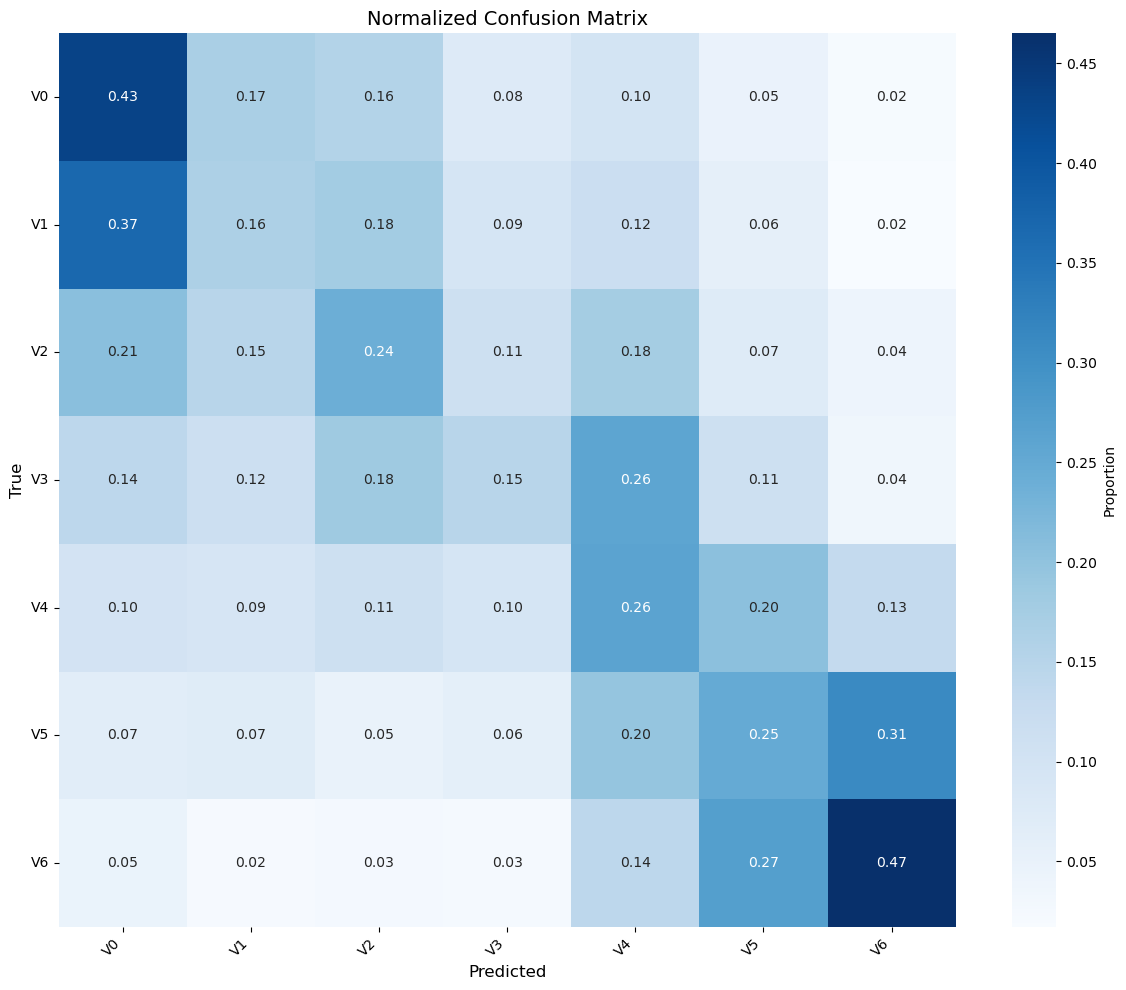


Epoch 6/20


Train Loss: 1.0780, Train Accuracy: 0.2892, Train Adjacent Accuracy: 0.6588

Epoch 7/20


Train Loss: 1.0712, Train Accuracy: 0.2914, Train Adjacent Accuracy: 0.6619

Epoch 8/20


Train Loss: 1.0657, Train Accuracy: 0.2915, Train Adjacent Accuracy: 0.6639

Epoch 9/20


Train Loss: 1.0584, Train Accuracy: 0.2996, Train Adjacent Accuracy: 0.6723

Epoch 10/20


Train Loss: 1.0547, Train Accuracy: 0.3035, Train Adjacent Accuracy: 0.6717



Overall Metrics:
Loss:                1.0910
Accuracy (Exact):    0.2826
Accuracy (±1 bin):   0.6575

Per-Class Metrics:
Label           Precision    Recall       F1-Score     Support   
----------------------------------------------------------------------
V0              0.2394       0.3588       0.2872       379       
V1              0.2581       0.2178       0.2363       583       
V2              0.2364       0.2364       0.2364       698       
V3              0.2219       0.2006       0.2107       668       
V4              0.3099       0.2948       0.3022       1228      
V5              0.3130       0.2466       0.2758       1018      
V6              0.3409       0.4783       0.3981       600       
----------------------------------------------------------------------
Macro Avg       0.2742       0.2905       0.2781       5174      
Weighted Avg    0.2818       0.2826       0.2789       5174      


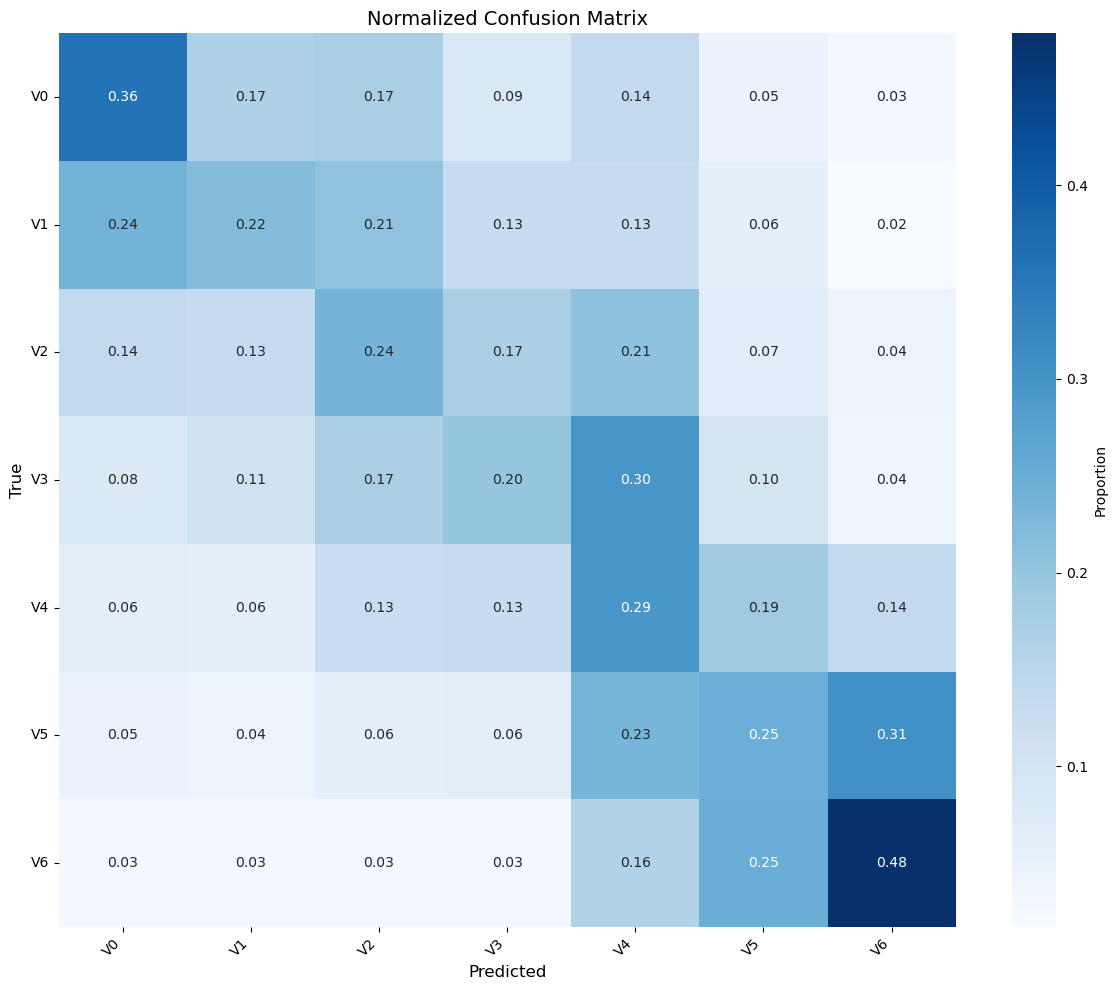


Epoch 11/20


Train Loss: 1.0474, Train Accuracy: 0.3040, Train Adjacent Accuracy: 0.6756

Epoch 12/20


Train Loss: 1.0424, Train Accuracy: 0.3071, Train Adjacent Accuracy: 0.6811

Epoch 13/20


Train Loss: 1.0362, Train Accuracy: 0.3089, Train Adjacent Accuracy: 0.6829

Epoch 14/20


Train Loss: 1.0304, Train Accuracy: 0.3145, Train Adjacent Accuracy: 0.6845

Epoch 15/20


Train Loss: 1.0251, Train Accuracy: 0.3181, Train Adjacent Accuracy: 0.6890



Overall Metrics:
Loss:                1.0901
Accuracy (Exact):    0.2797
Accuracy (±1 bin):   0.6479

Per-Class Metrics:
Label           Precision    Recall       F1-Score     Support   
----------------------------------------------------------------------
V0              0.2288       0.3562       0.2786       379       
V1              0.2583       0.1870       0.2169       583       
V2              0.2484       0.2163       0.2312       698       
V3              0.2286       0.2754       0.2498       668       
V4              0.3186       0.2516       0.2812       1228      
V5              0.3114       0.2230       0.2599       1018      
V6              0.3162       0.5533       0.4024       600       
----------------------------------------------------------------------
Macro Avg       0.2729       0.2947       0.2743       5174      
Weighted Avg    0.2824       0.2797       0.2728       5174      


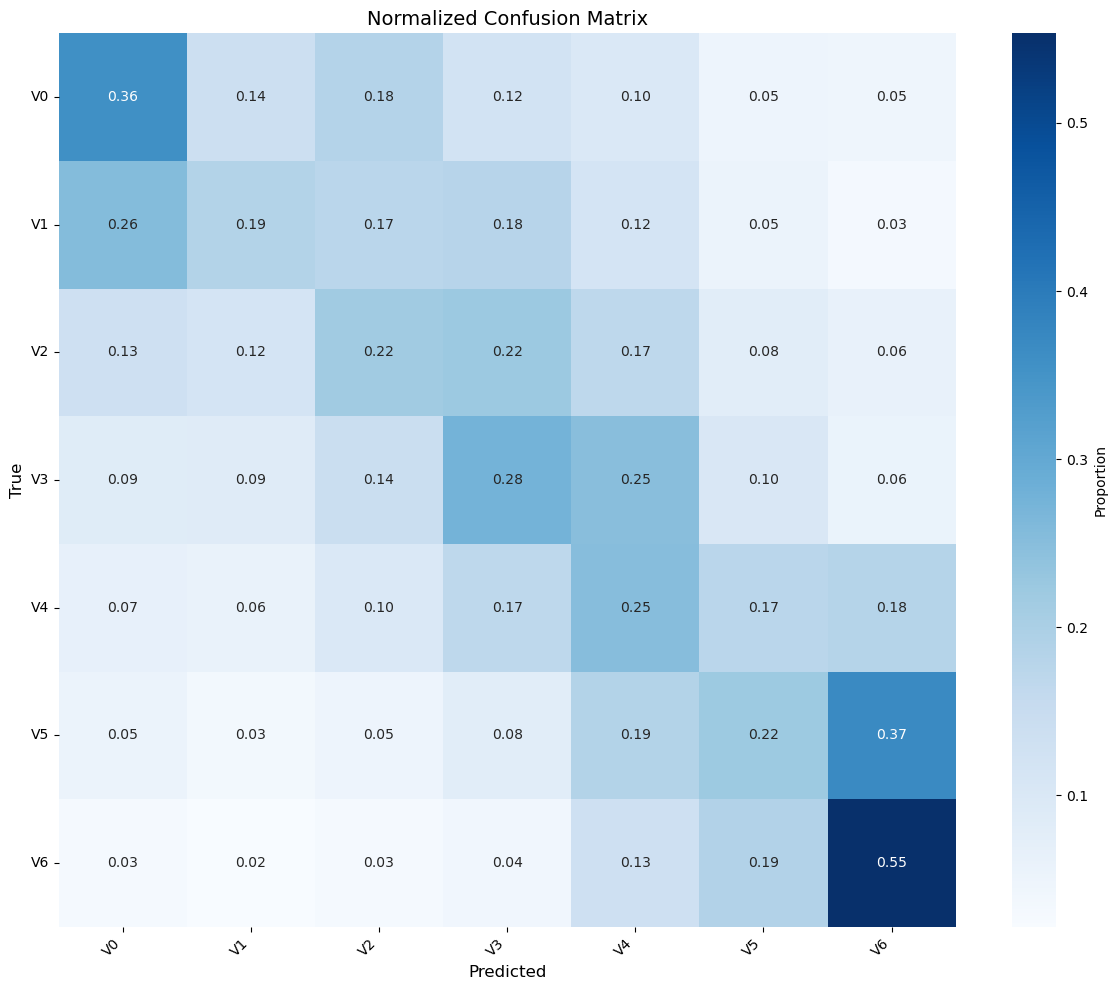


Epoch 16/20


Train Loss: 1.0176, Train Accuracy: 0.3199, Train Adjacent Accuracy: 0.6939

Epoch 17/20


Train Loss: 1.0099, Train Accuracy: 0.3221, Train Adjacent Accuracy: 0.6957

Epoch 18/20


Train Loss: 1.0044, Train Accuracy: 0.3286, Train Adjacent Accuracy: 0.7005

Epoch 19/20


Train Loss: 0.9982, Train Accuracy: 0.3300, Train Adjacent Accuracy: 0.7029

Epoch 20/20


Train Loss: 0.9910, Train Accuracy: 0.3345, Train Adjacent Accuracy: 0.7063



Overall Metrics:
Loss:                1.1053
Accuracy (Exact):    0.2723
Accuracy (±1 bin):   0.6376

Per-Class Metrics:
Label           Precision    Recall       F1-Score     Support   
----------------------------------------------------------------------
V0              0.2081       0.4063       0.2752       379       
V1              0.2302       0.2642       0.2460       583       
V2              0.2381       0.1504       0.1844       698       
V3              0.2377       0.1811       0.2056       668       
V4              0.3285       0.2199       0.2634       1228      
V5              0.2879       0.3094       0.2983       1018      
V6              0.3226       0.4833       0.3869       600       
----------------------------------------------------------------------
Macro Avg       0.2647       0.2878       0.2657       5174      
Weighted Avg    0.2760       0.2723       0.2654       5174      


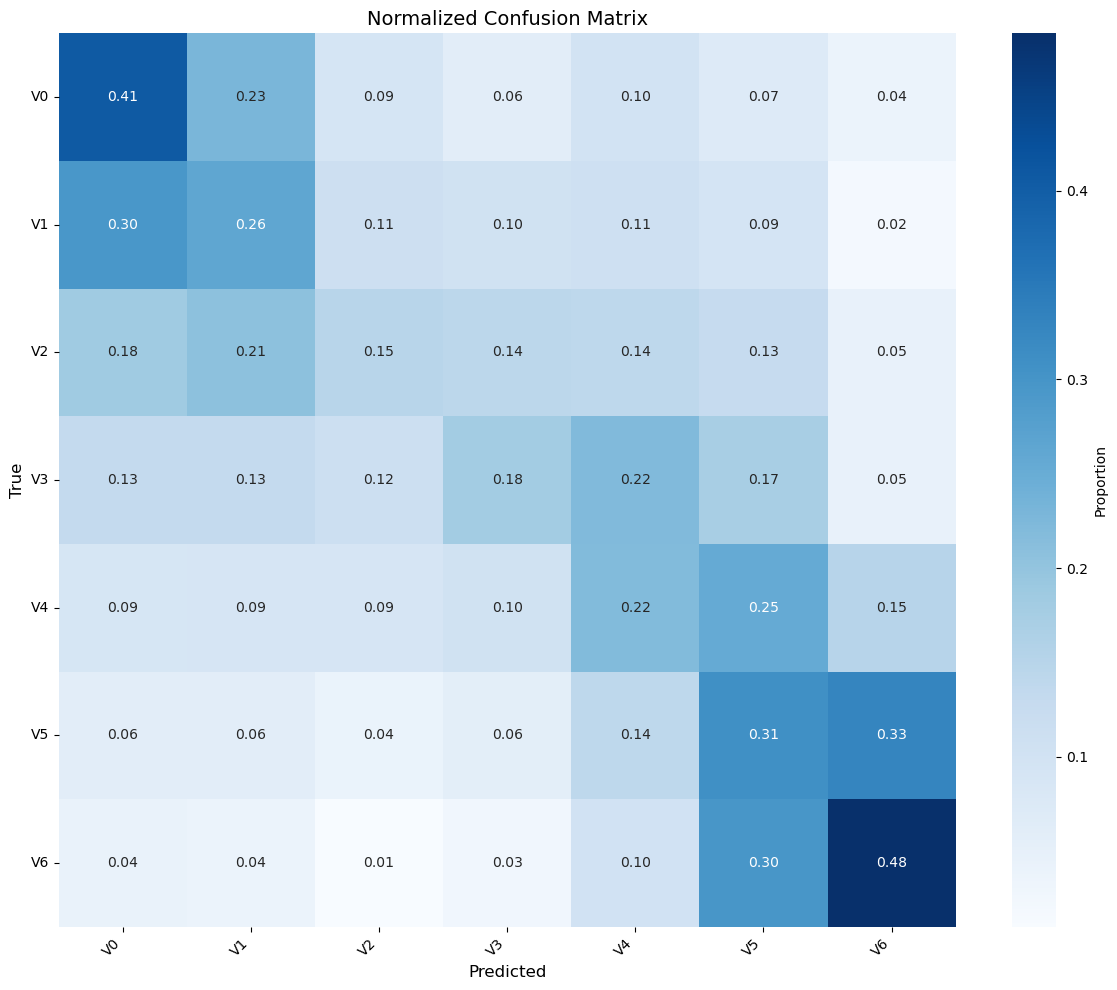

<All keys matched successfully>

In [278]:
EPOCHS = 20

optimizer = torch.optim.AdamW(
    face_val_model.parameters(),
    lr=1e-4,
    weight_decay=1e-4
)

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch + 1}/{EPOCHS}")
    
    # Train
    train_loss, train_acc, train_acc_adj = train_epoch(
        face_val_model, 
        face_val_train_loader, 
        optimizer, 
        class_weights=class_weights, 
        ce_weight=0.3, 
        reg_weight=0.5,
        adjacent_weight=0.2
    )
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Train Adjacent Accuracy: {train_acc_adj:.4f}")
    
    if (epoch + 1) % 5 == 0:
        # Evaluate
        results = evaluate_with_metrics(
            face_val_model, 
            face_val_test_loader, 
            valence_bin_labels, 
            class_weights=class_weights, 
            ce_weight=0.3, 
            reg_weight=0.5,
            adjacent_weight=0.2
            )
        print_detailed_metrics(results, valence_bin_labels)
        # Plot confusion matrix
        plot_confusion_matrix(results['confusion_matrix'], valence_bin_labels, normalize=True)

torch.save(face_val_model.state_dict(), os.path.join(model_dir, "face_val_model.pth"))
# Load the trained baseline model weights

face_val_model_raw = MLP(
    768,        # input size
    256, 64,   # hidden layers
    len(VALENCE_BINS),       # output size (valence bins)   
    activation=nn.ReLU,
    softmax=True,   
    batch=True
)
face_val_model = DeviceAwareModule(face_val_model_raw).to(DEVICE)


face_val_model.load_state_dict(torch.load(os.path.join(model_dir, "face_val_model.pth")))

In [165]:
face_val_network = Network(face_val_model, "face_val_model", batching=True)
face_val_network.optimizer = torch.optim.Adam(face_val_model.parameters(), lr=1e-3)

In [166]:
face_aro_model_raw = MLP(
    768,        # input size
    256, 64,   # hidden layers
    len(AROUSAL_BINS),       # output size (arousal bins)   
    activation=nn.ReLU,
    softmax=False,   
    batch=True
)
face_aro_model = DeviceAwareModule(face_aro_model_raw).to(DEVICE)


In [167]:
class FaceAroDataset(TorchDataset):
    def __init__(self, indices, feature_dir = os.path.join(data_dir, "pretrained_backbone", "faces")):
        self.indices = indices
        self.feature_dir = feature_dir

    def __getitem__(self, idx):
        if isinstance(idx, (tuple, list)):
            idx = idx[0]
        if isinstance(idx, Constant):
            idx = int(idx.value)

        idx = self.indices[idx]    
        arousal_bin = df.loc[idx]['arousal_bin']
        face_feature_list = []
        for _, box_row in df_boxes[df_boxes['index'] == idx].sort_values('face_rank').iterrows():
            face_rank = int(box_row['face_rank'])
            feature_path = os.path.join(self.feature_dir, f"face_{idx}_{face_rank}.pt")
            face_feature = torch.load(feature_path)
            face_feature_list.append(face_feature)

        if len(face_feature_list) == 0:
            face_avg = torch.zeros(768)

        else:
            face_avg = torch.mean(torch.stack(face_feature_list), dim=0)

        face_avg = face_avg.squeeze()

        return face_avg.to(DEVICE), arousal_bin
    
    def __len__(self):
        return len(self.indices)

In [168]:
face_aro_train_dataset = FaceAroDataset(train_indices)
face_aro_test_dataset = FaceAroDataset(test_indices)

face_aro_train_loader = DataLoader(face_aro_train_dataset, batch_size=batch_size, shuffle=True)
face_aro_test_loader = DataLoader(face_aro_test_dataset, batch_size=batch_size, shuffle=False)

In [169]:
class_counts = np.bincount(df['arousal_bin'].values)
class_weights = 1.0 / (class_counts + 1e-6)
class_weights /= class_weights.sum()


Epoch 1/20


Train Loss: 1.2243, Train Accuracy: 0.1578

Epoch 2/20


Train Loss: 1.2033, Train Accuracy: 0.1422

Epoch 3/20


Train Loss: 1.1929, Train Accuracy: 0.1616

Epoch 4/20


Train Loss: 1.1863, Train Accuracy: 0.1622

Epoch 5/20


Train Loss: 1.1796, Train Accuracy: 0.1654



Overall Metrics:
Loss:                1.1785
Accuracy (Exact):    0.1488
Accuracy (±1 bin):   0.4163

Per-Class Metrics:
Label           Precision    Recall       F1-Score     Support   
----------------------------------------------------------------------
A0              0.0658       0.2778       0.1065       288       
A1              0.2127       0.3929       0.2760       901       
A2              0.2339       0.0467       0.0779       1092      
A3              0.0556       0.0039       0.0072       1035      
A4              0.1818       0.0393       0.0647       915       
A5              0.1400       0.2027       0.1656       592       
A6              0.1316       0.3561       0.1922       351       
----------------------------------------------------------------------
Macro Avg       0.1459       0.1885       0.1271       5174      
Weighted Avg    0.1583       0.1488       0.1153       5174      


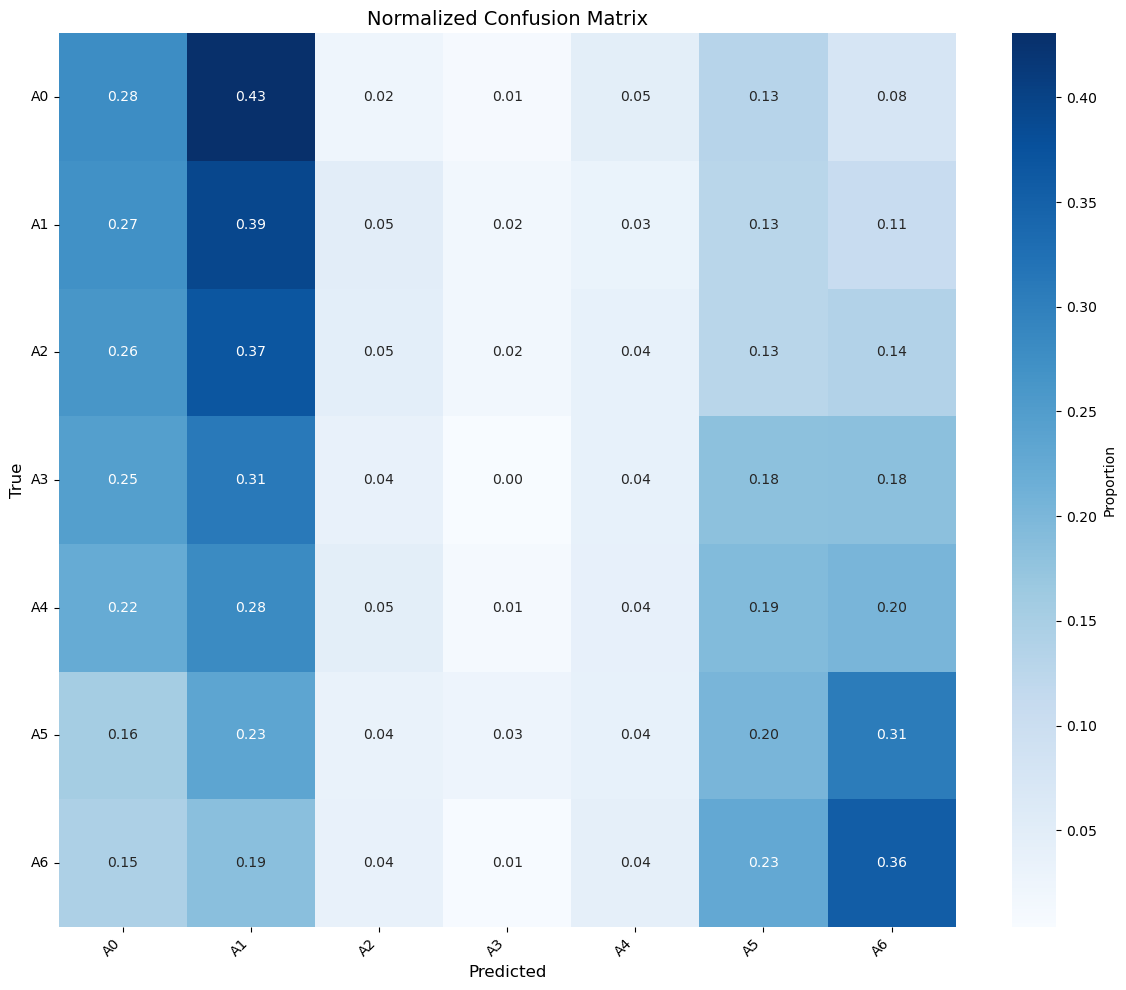


Epoch 6/20


Train Loss: 1.1754, Train Accuracy: 0.1707

Epoch 7/20


Train Loss: 1.1700, Train Accuracy: 0.1672

Epoch 8/20


Train Loss: 1.1635, Train Accuracy: 0.1670

Epoch 9/20


Train Loss: 1.1567, Train Accuracy: 0.1682

Epoch 10/20


Train Loss: 1.1516, Train Accuracy: 0.1709



Overall Metrics:
Loss:                1.1831
Accuracy (Exact):    0.1658
Accuracy (±1 bin):   0.4457

Per-Class Metrics:
Label           Precision    Recall       F1-Score     Support   
----------------------------------------------------------------------
A0              0.0656       0.1771       0.0958       288       
A1              0.2377       0.2897       0.2611       901       
A2              0.2358       0.1593       0.1902       1092      
A3              0.1952       0.1101       0.1408       1035      
A4              0.2346       0.0208       0.0382       915       
A5              0.1416       0.1047       0.1204       592       
A6              0.1214       0.5043       0.1957       351       
----------------------------------------------------------------------
Macro Avg       0.1760       0.1951       0.1489       5174      
Weighted Avg    0.1998       0.1658       0.1529       5174      


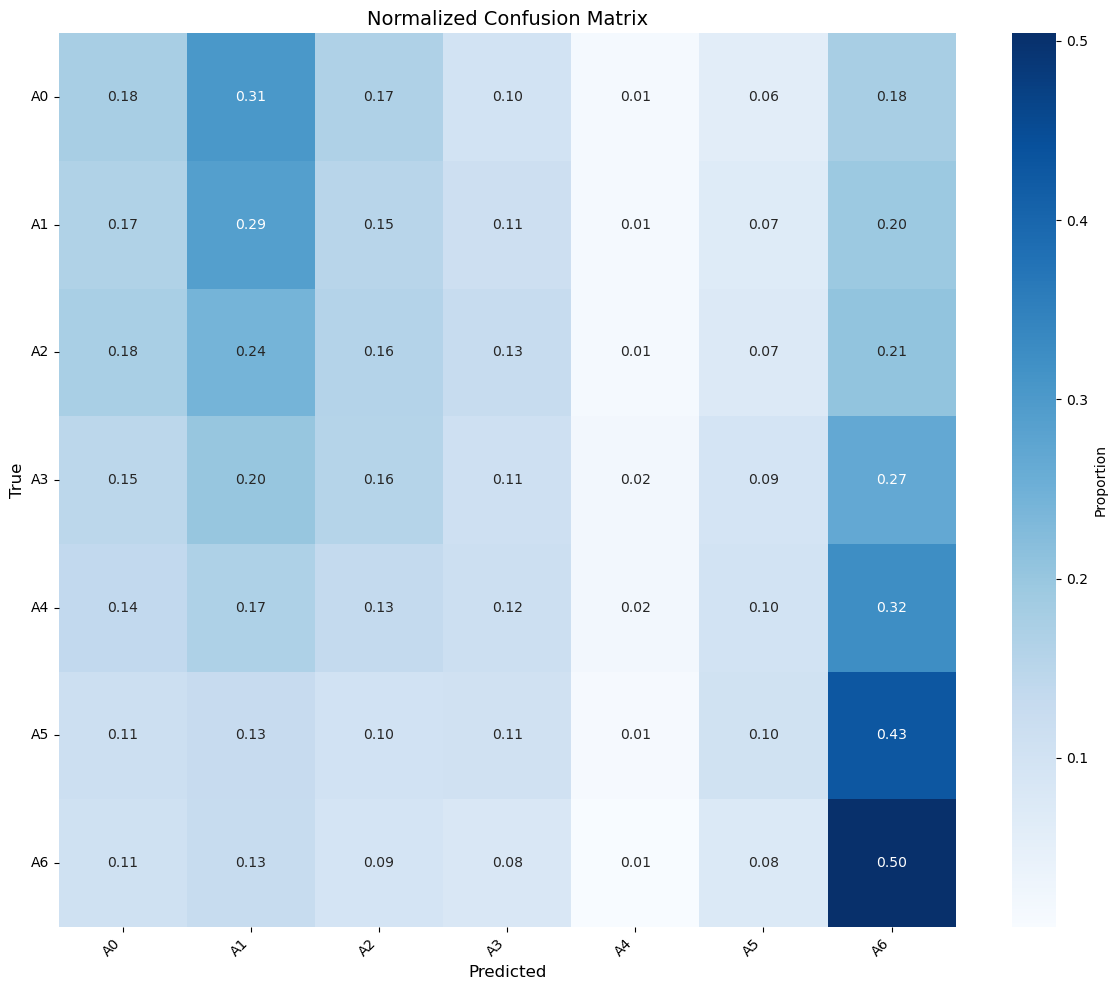


Epoch 11/20


Train Loss: 1.1439, Train Accuracy: 0.1752

Epoch 12/20


Train Loss: 1.1368, Train Accuracy: 0.1778

Epoch 13/20


Train Loss: 1.1278, Train Accuracy: 0.1833

Epoch 14/20


Train Loss: 1.1200, Train Accuracy: 0.1809

Epoch 15/20


Train Loss: 1.1117, Train Accuracy: 0.1825



Overall Metrics:
Loss:                1.2168
Accuracy (Exact):    0.1515
Accuracy (±1 bin):   0.4051

Per-Class Metrics:
Label           Precision    Recall       F1-Score     Support   
----------------------------------------------------------------------
A0              0.0659       0.3229       0.1094       288       
A1              0.1923       0.4506       0.2696       901       
A2              0.2444       0.0403       0.0692       1092      
A3              0.2000       0.0329       0.0564       1035      
A4              0.2542       0.0328       0.0581       915       
A5              0.1687       0.1149       0.1367       592       
A6              0.1397       0.3105       0.1927       351       
----------------------------------------------------------------------
Macro Avg       0.1808       0.1864       0.1274       5174      
Weighted Avg    0.2025       0.1515       0.1179       5174      


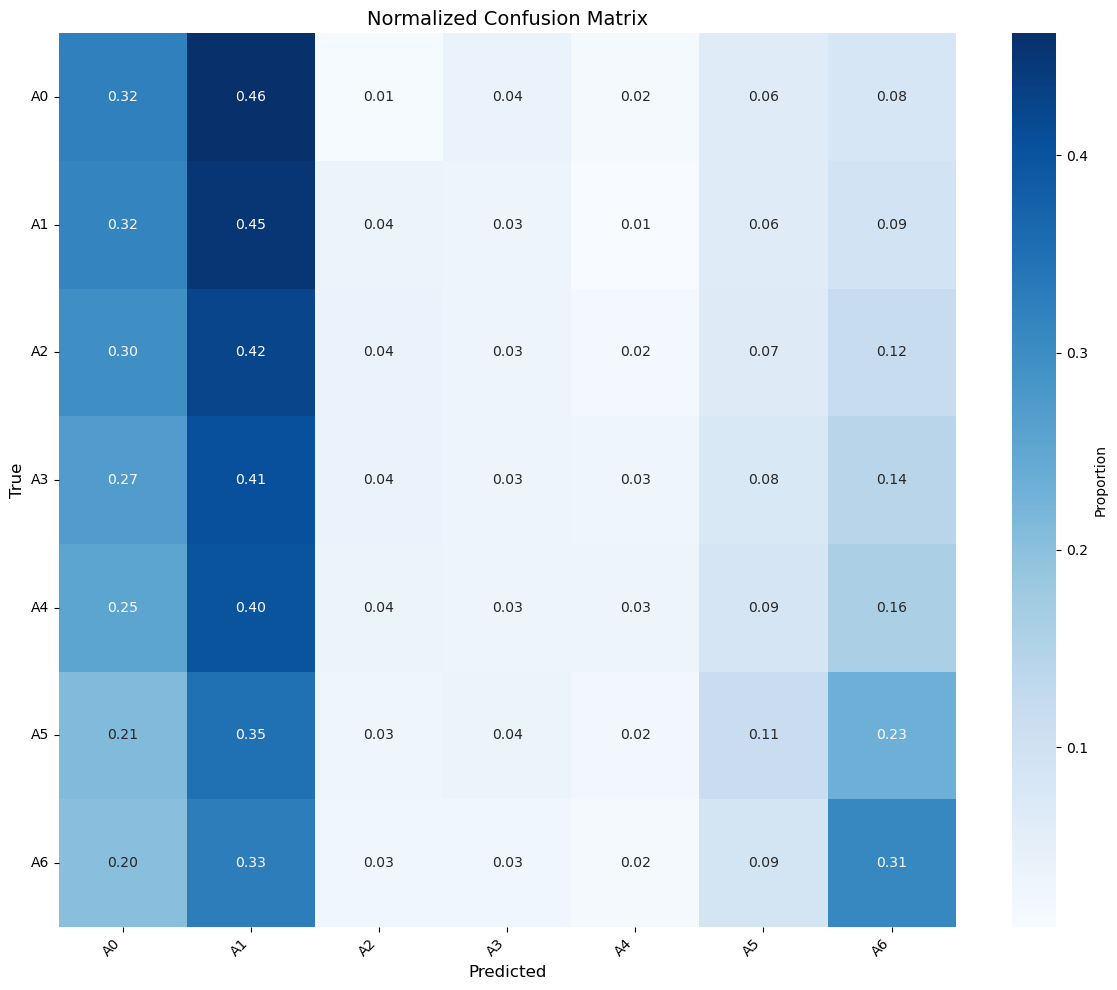


Epoch 16/20


Train Loss: 1.1002, Train Accuracy: 0.1863

Epoch 17/20


Train Loss: 1.0907, Train Accuracy: 0.1849

Epoch 18/20


Train Loss: 1.0814, Train Accuracy: 0.1946

Epoch 19/20


Train Loss: 1.0683, Train Accuracy: 0.1888

Epoch 20/20


Train Loss: 1.0571, Train Accuracy: 0.1981



Overall Metrics:
Loss:                1.2173
Accuracy (Exact):    0.1237
Accuracy (±1 bin):   0.3634

Per-Class Metrics:
Label           Precision    Recall       F1-Score     Support   
----------------------------------------------------------------------
A0              0.0643       0.4062       0.1110       288       
A1              0.2108       0.2031       0.2069       901       
A2              0.1807       0.0137       0.0255       1092      
A3              0.2153       0.0841       0.1209       1035      
A4              0.2267       0.0426       0.0718       915       
A5              0.1027       0.0828       0.0917       592       
A6              0.1112       0.4274       0.1765       351       
----------------------------------------------------------------------
Macro Avg       0.1588       0.1800       0.1149       5174      
Weighted Avg    0.1809       0.1237       0.1069       5174      


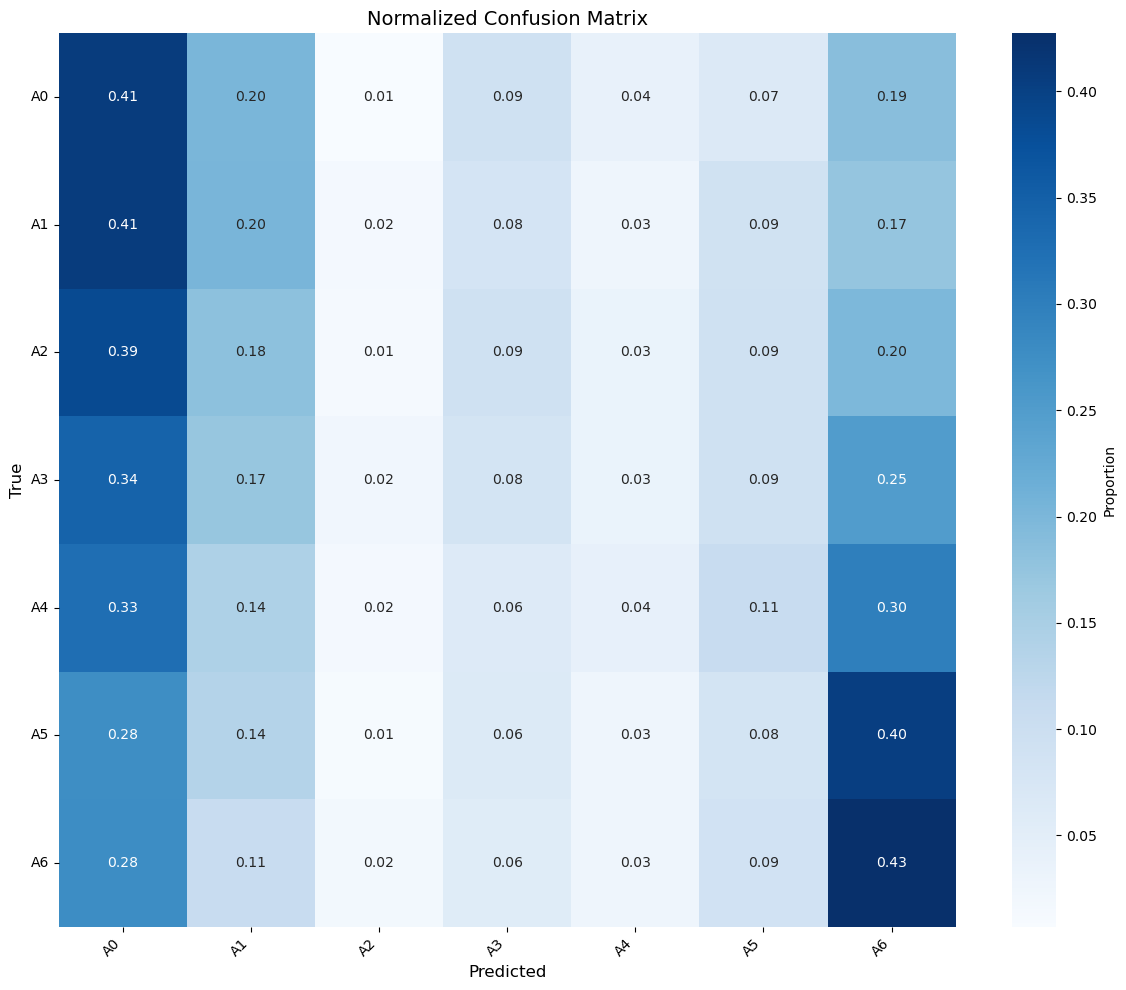

<All keys matched successfully>

In [170]:
EPOCHS = 20

optimizer = torch.optim.AdamW(
    face_aro_model.parameters(),
    lr=1e-4,
    weight_decay=1e-4
)

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch + 1}/{EPOCHS}")
    
    # Train
    train_loss, train_acc = train_epoch(face_aro_model, face_aro_train_loader, optimizer, class_weights=class_weights, ce_weight=0, reg_weight=1)
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
    
    if (epoch + 1) % 5 == 0:
        # Evaluate
        results = evaluate_with_metrics(face_aro_model, face_aro_test_loader, arousal_bin_labels, class_weights=class_weights, ce_weight=0, reg_weight=1)
        print_detailed_metrics(results, arousal_bin_labels)
        # Plot confusion matrix
        plot_confusion_matrix(results['confusion_matrix'], arousal_bin_labels, normalize=True)

torch.save(face_aro_model.state_dict(), os.path.join(model_dir, "face_aro_model.pth"))
# Load the trained baseline model weights

face_aro_model_raw = MLP(
    768,        # input size
    256, 64,   # hidden layers
    len(AROUSAL_BINS),       # output size (arousal bins)   
    activation=nn.ReLU,
    softmax=True,   
    batch=True
)
face_aro_model = DeviceAwareModule(face_aro_model_raw).to(DEVICE)


face_aro_model.load_state_dict(torch.load(os.path.join(model_dir, "face_aro_model.pth")))

In [ ]:
face_aro_network = Network(face_aro_model, "face_aro_model", batching=True)
face_aro_network.optimizer = torch.optim.Adam(face_aro_model.parameters(), lr=1e-3)

In [231]:
scene_val_model_raw = MLP(
    365,        # input size
    256, 64,   # hidden layers
    21,       # output size (valence bins)   
    activation=nn.ReLU,
    softmax=True,   
    batch=True
)
scene_val_model = DeviceAwareModule(scene_val_model_raw).to(DEVICE)

scene_val_network = Network(scene_val_model, "scene_val_model", batching=True)
scene_val_network.optimizer = torch.optim.Adam(scene_val_model.parameters(), lr=1e-3)

In [232]:
scene_aro_model_raw = MLP(
    365,        # input size
    256, 64,   # hidden layers
    21,       # output size (arousal bins)   
    activation=nn.ReLU,
    softmax=True,   
    batch=True
)
scene_aro_model = DeviceAwareModule(scene_aro_model_raw).to(DEVICE)

scene_aro_network = Network(scene_aro_model, "scene_aro_model", batching=True)
scene_aro_network.optimizer = torch.optim.Adam(scene_aro_model.parameters(), lr=1e-3)

In [233]:
class FaceFeatureDataset(DPLDataset):
    def __init__(self, indices, feature_dir):
        self.indices = indices
        self.feature_dir = feature_dir

    def __getitem__(self, idx):
        if isinstance(idx, (tuple, list)):
            idx = idx[0]
        if isinstance(idx, Constant):
            idx = int(idx.value)

        # Load all face logits (7 each), average; if none, use neutral
        face_rows = df_boxes[df_boxes['index'] == idx].sort_values('face_rank')
        face_features_list = []
        for _, box_row in face_rows.iterrows():
            face_rank = int(box_row['face_rank'])
            face_prediction_file = os.path.join(self.feature_dir, "faces", f"face_{idx}_{face_rank}.pt")
            face_features = torch.load(face_prediction_file, map_location="cpu")  # (7,)
            face_features_list.append(face_features)

        if len(face_features_list) == 0:
            face_avg = torch.zeros(7, dtype=torch.float32)
            face_avg[4] = 1.0  # neutral
        else:
            face_avg = torch.stack(face_features_list).mean(dim=0)  # (7,)

        return face_avg
    
    def __len__(self):
        return len(self.indices)
    
    def to_query(self, i):
        pass

face_features_train = FaceFeatureDataset(train_indices, os.path.join(data_dir, "pretrained_logits"))
face_features_test = FaceFeatureDataset(test_indices, os.path.join(data_dir, "pretrained_logits"))        

In [234]:
class SceneFeatureDataset(DPLDataset):
    def __init__(self, indices, feature_dir):
        self.indices = indices
        self.feature_dir = feature_dir

    def __getitem__(self, idx):
        if isinstance(idx, (tuple, list)):
            idx = idx[0]
        if isinstance(idx, Constant):
            idx = int(idx.value)

        scene_prediction_file = os.path.join(self.feature_dir, "scenes", f"scene_{idx}.pt")
        scene_features = torch.load(scene_prediction_file, map_location="cpu")  # (7,)

        return scene_features
    
    def __len__(self):
        return len(self.indices)
    
    def to_query(self, i):
        pass

scene_features_train = SceneFeatureDataset(train_indices, os.path.join(data_dir, "pretrained_logits"))
scene_features_test = SceneFeatureDataset(test_indices, os.path.join(data_dir, "pretrained_logits"))

In [235]:
emotion_va_bins

{'trust': (15, 9),
 'anticipation': (12, 8),
 'fear': (6, 11),
 'anger': (5, 12),
 'joy': (16, 10),
 'sadness': (5, 11),
 'disgust': (7, 8),
 'surprise': (12, 9)}

In [236]:
def closest_emotion(CV, CA):
    # Extract values from Constant objects
    cv_val = CV.value if isinstance(CV, Constant) else CV
    ca_val = CA.value if isinstance(CA, Constant) else CA
    
    closest_emo = None
    min_distance = float('inf')
    for emo, (EV, EA) in emotion_va_bins.items():
        DX = cv_val - EV
        DY = ca_val - EA
        D = (DX * DX + DY * DY) ** 0.5
        if D < min_distance:
            min_distance = D
            closest_emo = emo

    emo_id = LABEL_TO_ID[closest_emo]

    return Constant(emo_id)

In [237]:
from deepproblog.engines import ApproximateEngine
heuristic2 = ApproximateEngine.geometric_mean

model = Model(os.path.join(prolog_dir, "model_5_1.pl"), [face_val_network, face_aro_network, scene_val_network, scene_aro_network])
# model.set_engine(ExactEngine(model))
model.set_engine(ApproximateEngine(model, 10, heuristic2))

model.register_foreign(closest_emotion, "closest_emotion", 2, 1)

model.add_tensor_source("face_features_train", face_features_train)
model.add_tensor_source("scene_features_train", scene_features_train)
model.add_tensor_source("face_features_test", face_features_test)
model.add_tensor_source("scene_features_test", scene_features_test)

In [238]:
class FEQUeryDataset(DPLDataset):
    def __init__(self, indices, dataset_name):
        self.indices = indices
        self.dataset_name = dataset_name

    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, index):
        pass

    def to_query(self, idx):
        idx = self.indices[idx]
        label_str = df.iloc[idx]['emotion']
        label_id = LABEL_TO_ID[label_str]

        return Query(
            Term("final_emotion",
                Term("tensor", Term(f"face_features_{self.dataset_name}", Constant(idx))),
                Term("tensor", Term(f"scene_features_{self.dataset_name}", Constant(idx))),
                Constant(label_id)
                )
        )
    
train_dataset = FEQUeryDataset(train_indices, "train")
test_dataset = FEQUeryDataset(test_indices, "test")

In [239]:
train_dataset.to_query(0)

(1.0::final_emotion(tensor(face_features_train(2405)),tensor(scene_features_train(2405)),4), {})

In [240]:
def debug_query(model, pred_name, *args, substitution=None):
    """Helper to test intermediate predicates"""
    query = Query(Term(pred_name, *args), substitution=substitution)
    print(f"\n{'='*60}")
    print(f"Testing: {pred_name}")
    print(f"{'='*60}")
    model.eval()
    results = model.solve([query])
    result = results[0].result
    
    # Print probabilities nicely
    for key, prob in sorted(result.items(), key=lambda x: -x[1]):
        print(f"  {key}: {prob:.4f}")
    
    return result

In [241]:
test_idx = np.random.choice(test_indices)

debug_query(model,
            "closest_emotion",
            Constant(5),
            Constant(12),
            Var("E"))

debug_query(model,
            "test_face_val_bin",
            Term("tensor", Term("face_features_test", Constant(test_idx))),
            Var("VBin"))

debug_query(model,
            "test_face_aro_bin",
            Term("tensor", Term("face_features_test", Constant(test_idx))),
            Var("ABin"))

debug_query(model,
            "test_scene_val_bin",
            Term("tensor", Term("scene_features_test", Constant(test_idx))),
            Var("VBin"))

debug_query(model,
            "test_scene_aro_bin",
            Term("tensor", Term("scene_features_test", Constant(test_idx))),
            Var("ABin"))

debug_query(model,
            "test_combine_val_bin",
            Term("tensor", Term("face_features_test", Constant(test_idx))),
            Term("tensor", Term("scene_features_test", Constant(test_idx))),
            Var("CV"))

debug_query(model,
            "test_combine_aro_bin",
            Term("tensor", Term("face_features_test", Constant(test_idx))),
            Term("tensor", Term("scene_features_test", Constant(test_idx))),
            Var("CA"))

debug_query(model,
            "final_emotion",
            Term("tensor", Term("face_features_test", Constant(test_idx))),
            Term("tensor", Term("scene_features_test", Constant(test_idx))),
            Constant(LABEL_TO_ID[df.iloc[test_idx]['emotion']]))

print("Debugging queries done.")


Testing: closest_emotion
  closest_emotion(5,12,0): 1.0000

Testing: test_face_val_bin
  test_face_val_bin(tensor(face_features_test(12193)),8): 0.0609
  test_face_val_bin(tensor(face_features_test(12193)),12): 0.0568
  test_face_val_bin(tensor(face_features_test(12193)),1): 0.0566
  test_face_val_bin(tensor(face_features_test(12193)),18): 0.0550
  test_face_val_bin(tensor(face_features_test(12193)),20): 0.0531
  test_face_val_bin(tensor(face_features_test(12193)),13): 0.0524
  test_face_val_bin(tensor(face_features_test(12193)),5): 0.0519
  test_face_val_bin(tensor(face_features_test(12193)),7): 0.0515
  test_face_val_bin(tensor(face_features_test(12193)),0): 0.0506
  test_face_val_bin(tensor(face_features_test(12193)),16): 0.0498

Testing: test_face_aro_bin
  test_face_aro_bin(tensor(face_features_test(12193)),0): 0.0671
  test_face_aro_bin(tensor(face_features_test(12193)),17): 0.0580
  test_face_aro_bin(tensor(face_features_test(12193)),5): 0.0571
  test_face_aro_bin(tensor(face_f

In [ ]:
train_loader = DPLDataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [243]:
train_obj = train_model(
    model,
    train_loader,
    5,
    batch_size=batch_size,
    log_iter=log_iter
)

Training  for 5 epoch(s)
Epoch 1
Iteration:  2 	s:6.9489 	Average Loss:  4.334870085120201
Iteration:  4 	s:16.3592 	Average Loss:  7.851691976189613
Iteration:  6 	s:12.8264 	Average Loss:  6.288310378789902
Iteration:  8 	s:12.0902 	Average Loss:  5.522166226059198
Iteration:  10 	s:11.6634 	Average Loss:  4.810750685632229
Iteration:  12 	s:12.5543 	Average Loss:  4.515112046152353
Iteration:  14 	s:12.3480 	Average Loss:  4.250451292842627
Iteration:  16 	s:12.2610 	Average Loss:  3.970181681215763
Iteration:  18 	s:11.9936 	Average Loss:  3.6256477162241936
Iteration:  20 	s:12.0579 	Average Loss:  3.4114834647625685
Iteration:  22 	s:12.3569 	Average Loss:  3.523930437862873
Iteration:  24 	s:11.9837 	Average Loss:  3.178126698359847
Iteration:  26 	s:12.3767 	Average Loss:  3.1057228334248066
Iteration:  28 	s:11.7233 	Average Loss:  2.9210910983383656
Iteration:  30 	s:12.4318 	Average Loss:  2.8178756134584546
Iteration:  32 	s:12.1512 	Average Loss:  2.8348735980689526
Iterat

KeyboardInterrupt: 

In [244]:
results = evaluate_dpl_with_metrics(model, test_dataset)
print_dpl_detailed_metrics(results, fe_labels)

Accuracy:  0.3693467336683417

Overall Metrics:
Accuracy: 0.3693

Per-Class Metrics:
Emotion         Precision    Recall       F1-Score     Support   
----------------------------------------------------------------------
anger           0.2500       0.0235       0.0429       511       
anticipation    0.2785       0.7828       0.4108       1183      
disgust         0.0000       0.0000       0.0000       199       
fear            0.0000       0.0000       0.0000       461       
joy             0.5419       0.6857       0.6054       1416      
sadness         0.3333       0.0039       0.0077       512       
surprise        0.0000       0.0000       0.0000       167       
trust           0.0000       0.0000       0.0000       725       
----------------------------------------------------------------------
Macro Avg       0.1755       0.1870       0.1334       5174      
Weighted Avg    0.2696       0.3693       0.2646       5174      


In [245]:
def plot_confusion_matrix(cm, label_names, normalize=False):
    """Plot confusion matrix with better formatting"""
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = '.2f'
        title = 'Normalized Confusion Matrix'
    else:
        fmt = 'd'
        title = 'Confusion Matrix'
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt=fmt, cmap='Blues',
                xticklabels=label_names, yticklabels=label_names,
                cbar_kws={'label': 'Count' if not normalize else 'Proportion'})
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('True', fontsize=12)
    plt.title(title, fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

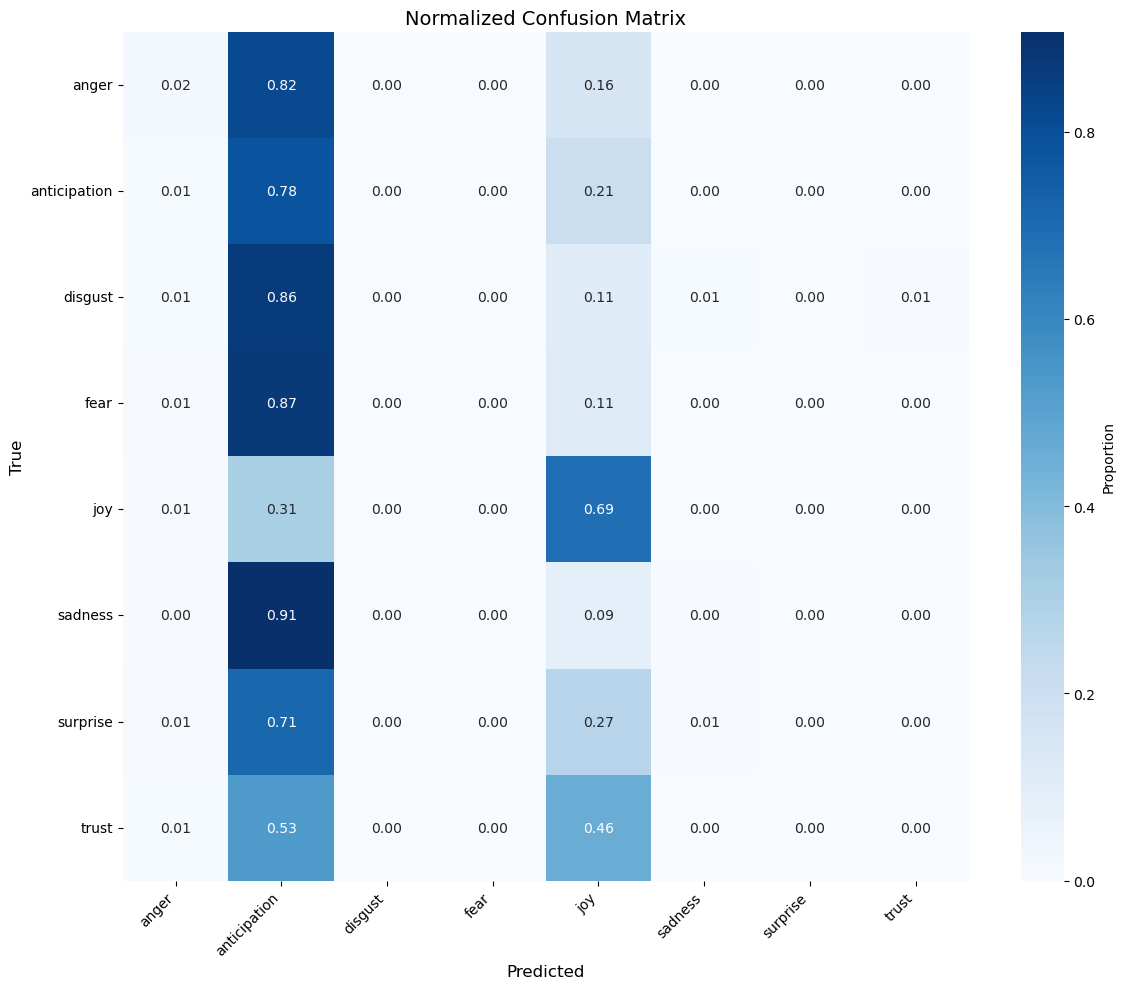

In [246]:
plot_confusion_matrix(results['confusion_matrix'], fe_labels, normalize=True)